<h1>Programming Exercise 8: Anomaly Detection and Recommender Systems</h1>
<h3>Introduction</h3>
In this exercise, we will implement the anomaly detection algorithm and apply it to detect failing servers on a network. In the second part, we will use collaborative filtering to build a recommender system for movies. To begin, we import necessary libraries. 

In [1]:
# used for manipulating directory paths
import os
from os.path import join

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot
import matplotlib as mpl

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots within the notebook
%matplotlib inline

<h3>1 Anomaly detection</h3>
In this exercise, we will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. Whil operating, we collected m = 307 example of how they were behaving. We suspect the vast majority are "normal", but there may be some anomalous examples.

We will use a Gaussian model to detect anomalous example in the dataset. We begin on a 2D dataset to visualize what the algorithm is doing. The following cell will visualize the dataset.

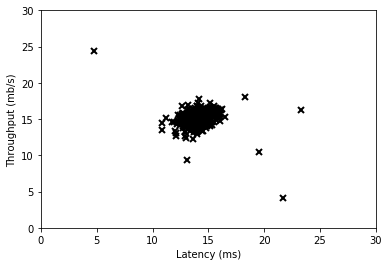

In [2]:
#  The following command loads the dataset.
data = loadmat(os.path.join('Data', 'ex8data1.mat'))
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

#  Visualize the example dataset
pyplot.plot(X[:, 0], X[:, 1], 'bx', mew=2, mec='k', ms=6)
pyplot.axis([0, 30, 0, 30])
pyplot.xlabel('Latency (ms)')
pyplot.ylabel('Throughput (mb/s)')
pass

To perform anomaly detection, we first need to fit a model to the data's distribution. To do so, we need to estimate the mean and variance parameters.

In [3]:
def estimateGaussian(X):
    """
    This function estimates the parameters of a Gaussian distribution
    using a provided dataset.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n) with each n-dimensional 
        data point in one row, and each total of m data points.
    
    Returns
    -------
    mu : array_like 
        A vector of shape (n,) containing the means of each dimension.
    
    sigma2 : array_like
        A vector of shape (n,) containing the computed
        variances of each dimension.
    """
    m, n = X.shape
    mu = np.zeros(n)
    sigma2 = np.zeros(n)

    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2

The following cells visualize this distribution and how our dataset falls into it.

In [4]:
def multivariateGaussian(X, mu, Sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.

    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n). Where there are m examples of n-dimensions.

    mu : array_like
        A vector of shape (n,) contains the means for each dimension (feature).

    Sigma2 : array_like
        Either a vector of shape (n,) containing the variances of independent features
        (i.e. it is the diagonal of the correlation matrix), or the full
        correlation matrix of shape (n x n) which can represent dependent features.

    Returns
    ------
    p : array_like
        A vector of shape (m,) which contains the computed probabilities at each of the
        provided examples.
    """
    k = mu.size

    # if sigma is given as a diagonal, compute the matrix
    if Sigma2.ndim == 1:
        Sigma2 = np.diag(Sigma2)

    X = X - mu
    p = (2 * np.pi) ** (- k / 2) * np.linalg.det(Sigma2) ** (-0.5)\
        * np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(Sigma2)) * X, axis=1))
    return p

In [5]:
def visualizeFit(X, mu, sigma2):
    """
    Visualize the dataset and its estimated distribution.
    This visualization shows you the  probability density function of the Gaussian distribution.
    Each example has a location (x1, x2) that depends on its feature values.

    Parameters
    ----------
    X : array_like
        The dataset of shape (m x 2). Where there are m examples of 2-dimensions. We need at most
        2-D features to be able to visualize the distribution.

    mu : array_like
        A vector of shape (n,) contains the means for each dimension (feature).

    sigma2 : array_like
        Either a vector of shape (n,) containing the variances of independent features
        (i.e. it is the diagonal of the correlation matrix), or the full
        correlation matrix of shape (n x n) which can represent dependent features.
    """

    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivariateGaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, sigma2)
    Z = Z.reshape(X1.shape)

    pyplot.plot(X[:, 0], X[:, 1], 'bx', mec='b', mew=2, ms=8)

    if np.all(abs(Z) != np.inf):
        pyplot.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), zorder=100)

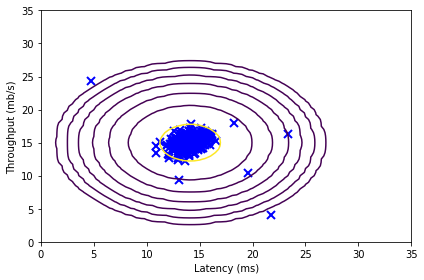

In [6]:
#  Estimate my and sigma2
mu, sigma2 = estimateGaussian(X)

#  Returns the density of the multivariate normal at each data point (row) 
#  of X
p = multivariateGaussian(X, mu, sigma2)

#  Visualize the fit
visualizeFit(X,  mu, sigma2)
pyplot.xlabel('Latency (ms)')
pyplot.ylabel('Throughput (mb/s)')
pyplot.tight_layout()

Now that we have estimated the Gaussian parameters, we can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more liekly to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross-validation set. In this part of the exercise, we will implement an algorithm to select the threshold epsilon using the F1 score on a cross validation set. 

In [7]:
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers based
    on the results from a validation set and the ground truth.
    
    Parameters
    ----------
    yval : array_like
        The ground truth labels of shape (m, ).
    
    pval : array_like
        The precomputed vector of probabilities based on mu and sigma2 parameters. It's shape is also (m, ).
    
    Returns
    -------
    bestEpsilon : array_like
        A vector of shape (n,) corresponding to the threshold value.
    
    bestF1 : float
        The value for the best F1 score.
    """
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
   
    for epsilon in np.linspace(1.01*min(pval), max(pval), 1000):
        predictions = (pval < epsilon)
        tp = np.sum((predictions == 1) & (yval == 1))
        fp = np.sum((predictions == 1) & (yval == 0))
        fn = np.sum((predictions == 0) & (yval == 1))
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = (2*prec*rec) / (prec + rec)

        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

The following cell will run our threshold selection function and circle the anomalies in the plot.

Best epsilon found using cross-validation: 9.00e-05
Best F1 on Cross Validation Set:  0.875000


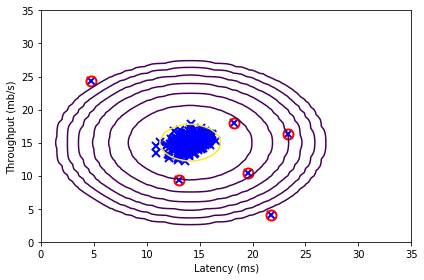

In [8]:
pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set:  %f' % F1)

#  Find the outliers in the training set and plot the
outliers = p < epsilon

#  Visualize the fit
visualizeFit(X,  mu, sigma2)
pyplot.xlabel('Latency (ms)')
pyplot.ylabel('Throughput (mb/s)')
pyplot.tight_layout()

#  Draw a red circle around those outliers
pyplot.plot(X[outliers, 0], X[outliers, 1], 'ro', ms=10, mfc='None', mew=2)
pass

Now that we have run our code successfuly on a small, low dimension dataset, we can apply it to higher dimensions. The following cell will do so on a dataset where each example is described by 11 features. 

In [9]:
#  Loads the second dataset. You should now have the
#  variables X, Xval, yval in your environment
data = loadmat(os.path.join('Data', 'ex8data2.mat'))
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

# Apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)

#  Training set 
p = multivariateGaussian(X, mu, sigma2)

#  Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2)

#  Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set          : %f\n' % F1)
print('\n# Outliers found: %d' % np.sum(p < epsilon))

Best epsilon found using cross-validation: 1.38e-18
Best F1 on Cross Validation Set          : 0.615385


# Outliers found: 117


<h3>2 Recommender Systems</h3>
In this part of the exercise, we will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of 1 to 5. The dataset has 943 users and 1682 movies. 

To begin, we load and plot the dataset ex8_movies.mat.

Average rating for movie 1 (Toy Story): 3.878319 / 5


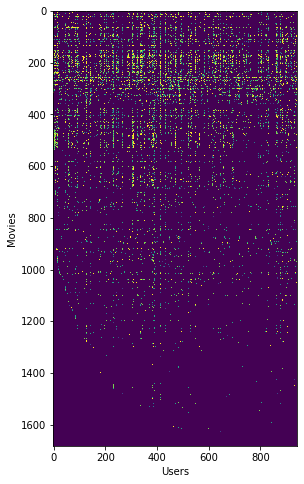

In [10]:
# Load data
data = loadmat(os.path.join('Data', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

# Y is a 1682x943 matrix, containing ratings (1-5) of 
# 1682 movies on 943 users

# R is a 1682x943 matrix, where R(i,j) = 1 
# if and only if user j gave a rating to movie i

# From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): %f / 5' %
      np.mean(Y[0, R[0, :] == 1]))

# We can "visualize" the ratings matrix by plotting it with imshow
pyplot.figure(figsize=(8, 8))
pyplot.imshow(Y)
pyplot.ylabel('Movies')
pyplot.xlabel('Users')
pyplot.grid(False)

We begin constructing our collaberative filtering algorithm by implementing the regularized cost function which returns our cost and cost gradient. 

In [11]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    """
    Collaborative filtering cost function.
    
    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the 
        concatenation of the feature vectors X and parameters Theta.
    
    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.
    
    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the 
        i-th movie was rated by the j-th user.
    
    num_users : int
        Total number of users.
    
    num_movies : int
        Total number of movies.
    
    num_features : int
        Number of features to learn.
    
    lambda_ : float, optional
        The regularization coefficient.
    
    Returns
    -------
    J : float
        The value of the cost function at the given params.
    
    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)
    """
    # Unfold the U and W matrices from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)

    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    predMovieRatings = np.dot(X, Theta.transpose())
    predMovieError = predMovieRatings - Y
    error_factor = np.multiply(predMovieError, R)
    J = (.5)*np.sum(np.sum(np.square(error_factor)))
    X_grad = error_factor.dot(Theta)
    Theta_grad = np.dot(error_factor.transpose(), X)
    J += (lambda_/2)*np.sum(np.sum(np.square(Theta))) + (lambda_/2)*np.sum(np.sum(np.square(X)))
    X_grad += lambda_*X
    Theta_grad += lambda_*Theta
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

We can confirm our gradient vector is correct by comparing it to a numerically computed alternative.

In [12]:
def computeNumericalGradient(J, theta, e=1e-4):
    """
    Computes the gradient using "finite differences" and gives us a numerical estimate of the
    gradient.

    Parameters
    ----------
    J : func
        The cost function which will be used to estimate its numerical gradient.

    theta : array_like
        The one dimensional unrolled network parameters. The numerical gradient is computed at
         those given parameters.

    e : float (optional)
        The value to use for epsilon for computing the finite difference.

    Returns
    -------
    numgrad : array_like
        The numerical gradient with respect to theta. Has same shape as theta.

    Notes
    -----
    The following code implements numerical gradient checking, and
    returns the numerical gradient. It sets `numgrad[i]` to (a numerical
    approximation of) the partial derivative of J with respect to the
    i-th input argument, evaluated at theta. (i.e., `numgrad[i]` should
    be the (approximately) the partial derivative of J with respect
    to theta[i].)
    """
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad

In [13]:
def checkCostFunction(cofiCostFunc, lambda_=0.):
    """
    Creates a collaborative filtering problem to check your cost function and gradients.
    It will output the  analytical gradients produced by your code and the numerical gradients
    (computed using computeNumericalGradient). These two gradient computations should result
    in very similar values.

    Parameters
    ----------
    cofiCostFunc: func
        Implementation of the cost function.

    lambda_ : float, optional
        The regularization parameter.
    """
    # Create small problem
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)

    # Zap out most entries
    Y = np.dot(X_t, Theta_t.T)
    Y[np.random.rand(*Y.shape) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1

    # Run Gradient Checking
    X = np.random.randn(*X_t.shape)
    Theta = np.random.randn(*Theta_t.shape)
    num_movies, num_users = Y.shape
    num_features = Theta_t.shape[1]

    params = np.concatenate([X.ravel(), Theta.ravel()])
    numgrad = computeNumericalGradient(
        lambda x: cofiCostFunc(x, Y, R, num_users, num_movies, num_features, lambda_), params)

    cost, grad = cofiCostFunc(params, Y, R, num_users,num_movies, num_features, lambda_)

    print(np.stack([numgrad, grad], axis=1))
    print('\nThe above two columns you get should be very similar.'
          '(Left-Your Numerical Gradient, Right-Analytical Gradient)')

    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    print('If your cost function implementation is correct, then '
          'the relative difference will be small (less than 1e-9).')
    print('\nRelative Difference: %g' % diff)

In [14]:
#  Check gradients by running checkCostFunction
checkCostFunction(cofiCostFunc, 1.5)

[[ 13.86445373  13.86445373]
 [ -0.50346339  -0.50346339]
 [ -0.25274807  -0.25274807]
 [ -7.16541284  -7.16541284]
 [  3.10313028   3.10313028]
 [  0.56829314   0.56829314]
 [ -1.04192584  -1.04192584]
 [  2.07795586   2.07795586]
 [ -0.68986789  -0.68986789]
 [  1.86079356   1.86079356]
 [ -2.40363355  -2.40363355]
 [ -0.20257324  -0.20257324]
 [ -2.35627103  -2.35627103]
 [  0.99584362   0.99584362]
 [ -0.94845546  -0.94845546]
 [  6.87482798   6.87482798]
 [ -1.90959988  -1.90959988]
 [  0.30039997   0.30039997]
 [  1.99317192   1.99317192]
 [ -0.71867099  -0.71867099]
 [ -0.13605671  -0.13605671]
 [-19.15609492 -19.15609492]
 [  6.2449762    6.2449762 ]
 [  0.34766409   0.34766409]
 [  3.77041093   3.77041093]
 [ -4.92417175  -4.92417175]
 [  0.16311157   0.16311157]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1

Now that we have a working collaborative filtering cost function and gradient, we can start training our algorithm to make movie recommendations. The following cells will take in your user ratings, train the model, and make recommendations.

In [15]:
def loadMovieList():
    """
    Reads the fixed movie list in movie_ids.txt and returns a list of movie names.

    Returns
    -------
    movieNames : list
        A list of strings, representing all movie names.
    """
    # Read the fixed movieulary list
    with open(join('Data', 'movie_ids.txt'),  encoding='ISO-8859-1') as fid:
        movies = fid.readlines()

    movieNames = []
    for movie in movies:
        parts = movie.split()
        movieNames.append(' '.join(parts[1:]).strip())
    return movieNames

In [16]:
#  Before we will train the collaborative filtering model, we will first
#  add ratings that correspond to a new user that we just observed. This
#  part of the code will also allow you to put in your own ratings for the
#  movies in our dataset!
movieList = loadMovieList()
n_m = len(movieList)

#  Initialize my ratings
my_ratings = np.zeros(n_m)

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
# Note that the index here is ID-1, since we start index from 0.
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:')
print('-----------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d stars: %s' % (my_ratings[i], movieList[i]))

New user ratings:
-----------------
Rated 4 stars: Toy Story (1995)
Rated 3 stars: Twelve Monkeys (1995)
Rated 5 stars: Usual Suspects, The (1995)
Rated 4 stars: Outbreak (1995)
Rated 5 stars: Shawshank Redemption, The (1994)
Rated 3 stars: While You Were Sleeping (1995)
Rated 5 stars: Forrest Gump (1994)
Rated 2 stars: Silence of the Lambs, The (1991)
Rated 4 stars: Alien (1979)
Rated 5 stars: Die Hard 2 (1990)
Rated 5 stars: Sphere (1998)


In [17]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).

    Parameters
    ----------
    Y : array_like
        The user ratings for all movies. A matrix of shape (num_movies x num_users).

    R : array_like
        Indicator matrix for movies rated by users. A matrix of shape (num_movies x num_users).

    Returns
    -------
    Ynorm : array_like
        A matrix of same shape as Y, after mean normalization.

    Ymean : array_like
        A vector of shape (num_movies, ) containing the mean rating for each movie.
    """
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)

    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean

In [18]:
#  Now, we will train the collaborative filtering model on a movie rating 
#  dataset of 1682 movies and 943 users

#  Load data
data = loadmat(os.path.join('Data', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  Add our own ratings to the data matrix
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

#  Useful Values
num_movies, num_users = Y.shape
num_features = 10

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options for scipy.optimize.minimize
options = {'maxiter': 100}

# Set Regularization
lambda_ = 10
res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                               num_movies, num_features, lambda_),
                        initial_parameters,
                        method='TNC',
                        jac=True,
                        options=options)
theta = res.x

# Unfold the returned theta back into U and W
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Recommender system learning completed.')

Recommender system learning completed.


In [19]:
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Ymean

movieList = loadMovieList()

ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(10):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], movieList[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))

Top recommendations for you:
----------------------------
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Someone Else's America (1995)

Original ratings provided:
--------------------------
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Sil